The notebook transforms kaggle data set (found here: https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres?select=lyrics-data.csv) to cleaned set to start Music_Lyrics capstone project.

This is the final pass and follows several exploratory attempts.  This fianl effort is a very focused and will produce a smaller subset of features than has been considered in total.  

In [47]:
import pandas as pd
import numpy as np
import s3fs
import os
import io
import boto3

import s3fs
fs = s3fs.S3FileSystem(anon=False,key='####',secret='####')

from dotenv import load_dotenv
load_dotenv(verbose=True)

def aws_session(region_name='us-east-1'):
    return boto3.session.Session(aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'), #looks for any .env file
                                aws_secret_access_key=os.getenv('AWS_ACCESS_KEY_SECRET'), #Has to be in same directory
                                region_name=region_name) #from above

def make_bucket(name, acl): 
    session = aws_session()
    s3_resource = session.resource('s3')
    return s3_resource.create_bucket(Bucket=name, ACL=acl)

def upload_file_to_bucket(bucket_name, file_path):
    session = aws_session()
    s3_resource = session.resource('s3')
    file_dir, file_name = os.path.split(file_path)

    bucket = s3_resource.Bucket(bucket_name)
    bucket.upload_file(
      Filename=file_path,
      Key=file_name,
      ExtraArgs={'ACL': 'public-read'}
    )

    s3_url = f"https://{bucket_name}.s3.amazonaws.com/{file_name}"
    return s3_url

def download_file_from_bucket(bucket_name, s3_key, dst_path):
    session = aws_session()
    s3_resource = session.resource('s3')
    bucket = s3_resource.Bucket(bucket_name)
    bucket.download_file(Key=s3_key, Filename=dst_path)

The genres data set comes in two .csv files. Downloading both using boto3 which requires an existing file on the local directory.

Download both halves of the genres dataset (found from Kaggle at:https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres?select=lyrics-data.csv).

In [2]:
!touch genres_lyrics.csv
!touch genres_genres.csv

download_file_from_bucket('worm-begin','genres_lyrics_data.csv','genres_lyrics.csv')
with open('genres_lyrics.csv') as fo:
    lyrics_df = pd.read_csv(fo)

download_file_from_bucket('worm-begin','genres_artists_data.csv','genres_genres.csv')
with open('genres_genres.csv') as fo:
    genres_df = pd.read_csv(fo)

In [3]:
lyrics_df.describe(include='all')

,ALink,SName,SLink,Lyric,Idiom
count,209522,209522,209522,209484,206375
unique,2993,128083,167499,164789,47
top,/chris-brown/,Intro,/edu-gueda/disk-amor.html,Instrumental,ENGLISH
freq,1176,80,6,592,114723


In [4]:
lyrics_df.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


In [5]:
genres_df.describe(include='all')

,Artist,Songs,Popularity,Link,Genre,Genres
count,3242,3242.000000,3242.000000,3242,3242,3238
unique,2940,NaN,NaN,2940,6,1777
top,Heytor Vianna,NaN,NaN,/rick-rock/,Rock,Sertanejo
freq,3,NaN,NaN,3,797,295
mean,NaN,53.907465,1.522455,NaN,NaN,NaN
std,NaN,78.212829,6.965121,NaN,NaN,NaN
min,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,4.000000,0.000000,NaN,NaN,NaN
50%,NaN,17.000000,0.000000,NaN,NaN,NaN
75%,NaN,77.000000,0.500000,NaN,NaN,NaN


In [6]:
genres_df.head()

,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
3,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
4,A Cruz Está Vazia,13,0.0,/a-cruz-esta-vazia/,Rock,Rock


Reduce genres_df to just artist-name (the key with lyrics_df) and drop dupes.

In [7]:
genres1_df = pd.DataFrame(genres_df, columns=['Link','Genre'])
genres2_df = genres1_df.rename(columns={'Link':'artist_name','Genre':'genre'})
genres2_df[genres2_df.duplicated(keep = False)]

,artist_name,genre


In [8]:
genres2_df.describe(include='all')

,artist_name,genre
count,3242,3242
unique,2940,6
top,/rick-rock/,Rock
freq,3,797


In [9]:
genres2_df.isnull().sum()

artist_name    0
genre          0
dtype: int64

In [10]:
genres2_df[genres2_df.duplicated(subset=['artist_name'])]

,artist_name,genre
1947,/10000-maniacs/,Pop
1975,/beastie-boys/,Rock
2002,/claudio-henrique-seven-music/,Sertanejo
2008,/crowded-house/,Rock
2012,/danni-carlos/,Rock
...,...,...
3227,/tati-quebra-barraco/,Hip Hop
3228,/valesca-popozuda/,Pop
3229,/vine-rodry/,Pop
3234,/leandro-sapucahy/,Pop


This merging the genre and lyric data sets on artist, with this many dulicated artists will explode the merge dataframe, with many, many repeats.

In [11]:
genres2_df.drop_duplicates(subset=['artist_name'],inplace=True)

In [12]:
genres2_df.describe(include='all')

,artist_name,genre
count,2940,2940
unique,2940,6
top,/biographia-54/,Rock
freq,1,755


In [13]:
genres2_df[genres2_df.duplicated(subset=['artist_name'])]

,artist_name,genre


Drop of dupes confirmed.

Reorder lyrics_df columns and rename IAW naming convention. Drop duplicates. Drop all but the ENGLISH lyrics.

In [14]:
lyrics2_df = lyrics_df.rename(columns={'ALink':'artist_name','SName':'song_name','SLink':'link','Lyric':'lyrics','Idiom':'language'})
lyrics3_df = (lyrics2_df[lyrics2_df['language']=='ENGLISH'])
lyrics3_df[lyrics3_df.duplicated(keep = False)]

,artist_name,song_name,link,lyrics,language
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH
...,...,...,...,...,...
207587,/sambo/,I Feel Good,/sambo/i-feel-good.html,"Whooooau!. I feel good, I knew that I would no...",ENGLISH
207592,/sambo/,Mercedes Benz,/sambo/mercedes-benz.html,"Oh Lord, won't you buy me a Mercedes Benz ?. M...",ENGLISH
207614,/sambo/,Suddenly I See,/sambo/suddenly-i-see.html,"Her face is a map of the world, is a map of th...",ENGLISH
207615,/sambo/,"Sunday, Bloody Sunday",/sambo/sunday-bloody-sunday.html,I can't believe the news today. I can't close ...,ENGLISH


In [15]:
lyrics3_df.describe(include='all')

,artist_name,song_name,link,lyrics,language
count,114723,114723,114723,114723,114723
unique,1198,70261,91611,90796,1
top,/chris-brown/,Home,/m-i-a/bad-girls.html,[This song is an instrumental.].,ENGLISH
freq,1174,61,6,17,114723


In [16]:
lyrics3_df.isnull().sum()

artist_name    0
song_name      0
link           0
lyrics         0
language       0
dtype: int64

Checking for and then removing duplicate lyrics (multiple artists doing the same song). Almost 24,000.

In [17]:
lyrics3_df[lyrics3_df.duplicated(subset=['lyrics'])]

,artist_name,song_name,link,lyrics,language
23,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
24,/10000-maniacs/,A Room For Everything,/10000-maniacs/a-room-for-everything.html,"You were looking away from me, western skies c...",ENGLISH
25,/10000-maniacs/,Across The Fields,/10000-maniacs/across-the-fields.html,"Well they left then in the morning, a hundred ...",ENGLISH
26,/10000-maniacs/,All That Never Happens,/10000-maniacs/all-that-never-happens.html,"She walks alone on the brick lane,. the breeze...",ENGLISH
29,/10000-maniacs/,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,For whom do the bells toll. When sentenced to ...,ENGLISH
...,...,...,...,...,...
207587,/sambo/,I Feel Good,/sambo/i-feel-good.html,"Whooooau!. I feel good, I knew that I would no...",ENGLISH
207592,/sambo/,Mercedes Benz,/sambo/mercedes-benz.html,"Oh Lord, won't you buy me a Mercedes Benz ?. M...",ENGLISH
207614,/sambo/,Suddenly I See,/sambo/suddenly-i-see.html,"Her face is a map of the world, is a map of th...",ENGLISH
207615,/sambo/,"Sunday, Bloody Sunday",/sambo/sunday-bloody-sunday.html,I can't believe the news today. I can't close ...,ENGLISH


In [18]:
lyrics3_df.drop_duplicates(subset=['lyrics'],inplace=True)

<ipython-input-18-c957743e557b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics3_df.drop_duplicates(subset=['lyrics'],inplace=True)


In [19]:
lyrics3_df[lyrics3_df.duplicated(subset=['lyrics'])]

,artist_name,song_name,link,lyrics,language


Merge lyrics_df with genre_df to add genre to a single df with the lyrics.

In [20]:
merged_genre_df = pd.merge(lyrics3_df,genres2_df,on = 'artist_name')

In [21]:
merged_genre_df.describe(include='all')

,artist_name,song_name,link,lyrics,language,genre
count,86391,86391,86391,86391,86391,86391
unique,1147,66856,86391,86391,1,6
top,/elvis-presley/,Intro,/a-ha/dot-the-i.html,Somber sister. This is a strange and bitter fr...,ENGLISH,Rock
freq,747,50,1,1,86391,47408


Strip the ' / ' from 'singer_name'.

In [22]:
merged_genre_df['artist_name'].replace('(/)','',regex=True, inplace = True)

In [23]:
merged_genre_df.head()

,artist_name,song_name,link,lyrics,language,genre
0,10000-maniacs,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH,Rock
1,10000-maniacs,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH,Rock
2,10000-maniacs,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH,Rock
3,10000-maniacs,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH,Rock
4,10000-maniacs,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH,Rock


Next steps will form final dataset.  Dropping artist name (prevent leakage to target variable 'genre'), link (pointless), language (all the same).  Dropping all genre but Rock, Pop, and Hip Hop.

These decisions are result of previous cleaning (with EDA) and pre-processing (with EDA).

In [24]:
merged_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86391 entries, 0 to 86390
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  86391 non-null  object
 1   song_name    86391 non-null  object
 2   link         86391 non-null  object
 3   lyrics       86391 non-null  object
 4   language     86391 non-null  object
 5   genre        86391 non-null  object
dtypes: object(6)
memory usage: 4.6+ MB


In [25]:
merged_genre_df.genre.unique()

array(['Rock', 'Pop', 'Hip Hop', 'Sertanejo', 'Samba', 'Funk Carioca'],
      dtype=object)

In [26]:
merged_genre_df.describe(include='all')

,artist_name,song_name,link,lyrics,language,genre
count,86391,86391,86391,86391,86391,86391
unique,1147,66856,86391,86391,1,6
top,elvis-presley,Intro,/a-ha/dot-the-i.html,Somber sister. This is a strange and bitter fr...,ENGLISH,Rock
freq,747,50,1,1,86391,47408


In [27]:
merged_genre_df.drop(['artist_name','link','language'], axis=1, inplace=True)

In [28]:
merged_genre_df.describe(include='all')

,song_name,lyrics,genre
count,86391,86391,86391
unique,66856,86391,6
top,Intro,Somber sister. This is a strange and bitter fr...,Rock
freq,50,1,47408


In [29]:
merged_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86391 entries, 0 to 86390
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song_name  86391 non-null  object
 1   lyrics     86391 non-null  object
 2   genre      86391 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB


In [31]:
# Two additional cleanups.  Found during further EDA.  Remove tiny genres, remove three
#songs that have NaN lyrics.

merged_genre_df.drop(merged_genre_df[merged_genre_df['genre']=='Samba'].index, inplace = True)
merged_genre_df.drop(merged_genre_df[merged_genre_df['genre']=='Sertanejo'].index, inplace = True)
merged_genre_df.drop(merged_genre_df[merged_genre_df['genre']=='Funk Carioca'].index, inplace = True)

merged_genre_df = merged_genre_df.dropna(axis=0, subset=['lyrics'])

In [32]:
merged_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86294 entries, 0 to 86310
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song_name  86294 non-null  object
 1   lyrics     86294 non-null  object
 2   genre      86294 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB


In [34]:
merged_genre_df.describe(include='all')

,song_name,lyrics,genre
count,86294,86294,86294
unique,66802,86294,3
top,Intro,Somber sister. This is a strange and bitter fr...,Rock
freq,50,1,47408


In [35]:
merged_genre_df.genre.unique()

array(['Rock', 'Pop', 'Hip Hop'], dtype=object)

In [45]:
merged_genre_df.to_csv('g_df')

In [46]:
g_df

,song_name,lyrics,genre
0,More Than This,I could feel at the time. There was no way of ...,Rock
1,Because The Night,"Take me now, baby, here as I am. Hold me close...",Rock
2,These Are Days,These are. These are days you'll remember. Nev...,Rock
3,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",Rock
4,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,Rock
...,...,...,...
86306,Smile,Smile though your heart. Is aching. Smile even...,Pop
86307,Something To Dance For,A dream like this. Not something. You wish for...,Pop
86308,The Same Heart,"Aah, yeah yeah. I see the spotlight in my drea...",Pop
86309,White Christmas,"I'm, dreaming of a white, Christmas. Just like...",Pop


In [50]:
upload_file_to_bucket('music-lyrics-chain','g_df')

'https://music-lyrics-chain.s3.amazonaws.com/g_df'

In [51]:
gg_df = pd.read_csv('s3://music-lyrics-chain/g_df')

In [52]:
gg_df

,Unnamed: 0,song_name,lyrics,genre
0,0,More Than This,I could feel at the time. There was no way of ...,Rock
1,1,Because The Night,"Take me now, baby, here as I am. Hold me close...",Rock
2,2,These Are Days,These are. These are days you'll remember. Nev...,Rock
3,3,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",Rock
4,4,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,Rock
...,...,...,...,...
86289,86306,Smile,Smile though your heart. Is aching. Smile even...,Pop
86290,86307,Something To Dance For,A dream like this. Not something. You wish for...,Pop
86291,86308,The Same Heart,"Aah, yeah yeah. I see the spotlight in my drea...",Pop
86292,86309,White Christmas,"I'm, dreaming of a white, Christmas. Just like...",Pop


In [53]:
type(gg_df)

pandas.core.frame.DataFrame

In [54]:
gg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86294 entries, 0 to 86293
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  86294 non-null  int64 
 1   song_name   86294 non-null  object
 2   lyrics      86294 non-null  object
 3   genre       86294 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


In next steps looking to identify the differences in the totals in each genre, divide g_df into a train and test set, and confirm the distribution of genres remains the same.

In [56]:
import os
import json
import time
import pickle
import requests
import time
import warnings
import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances



In [59]:
g_df.genre.value_counts()

Rock       47408
Pop        25325
Hip Hop    13561
Name: genre, dtype: int64

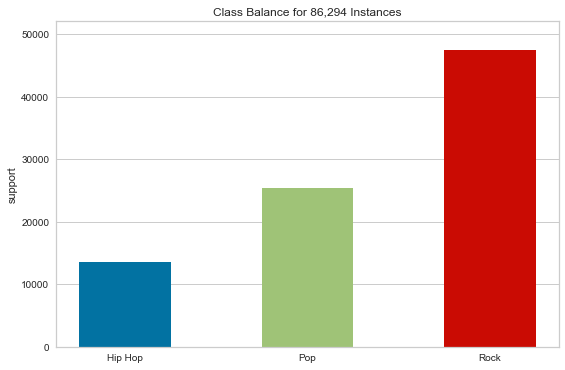

<AxesSubplot:title={'center':'Class Balance for 86,294 Instances'}, ylabel='support'>

In [58]:
X = g_df.iloc[:,:-1]
y = g_df["genre"]

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["Hip Hop", "Pop", "Rock"])

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [61]:
g_train=g_df.sample(frac=0.8,random_state=200) #random state is a seed value
g_test=g_df.drop(g_train.index)

In [62]:
type(g_train)

pandas.core.frame.DataFrame

In [63]:
g_train

,song_name,lyrics,genre
81102,Time On My Hands,"Seventy, eighty, ninety, party. Seventy, eight...",Pop
61033,Players,(singing) players. (T3). It's the seven eighty...,Hip Hop
771,Underground,When you're gone. When you're gone. It's like ...,Pop
34987,China White,Sometimes it seems the good times. Never will ...,Rock
75233,Banquet,Come to the dinner gong. The table is laden hi...,Pop
...,...,...,...
48980,Going For The One,(Anderson). Get the idea cross around the trac...,Rock
9458,Waiting For Superman,"She's watching the taxi driver, he pulls away....",Rock
44601,So Sad About Us,La la la la la la la. La la la la la la la. La...,Rock
71027,3 Letters (Feat. Pitbull),One love. Enrique Iglesias. Pitbull. I don't c...,Pop


In [64]:
g_train.describe(include='all')

,song_name,lyrics,genre
count,69035,69035,69035
unique,54882,69035,3
top,Intro,Somber sister. This is a strange and bitter fr...,Rock
freq,43,1,37883


In [66]:
g_train.genre.value_counts()

Rock       37883
Pop        20292
Hip Hop    10860
Name: genre, dtype: int64

Percentages look good.  Same as total set: 55%, 29%, 15%.

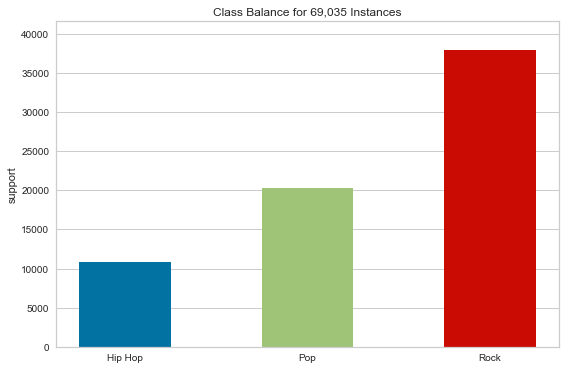

<AxesSubplot:title={'center':'Class Balance for 69,035 Instances'}, ylabel='support'>

In [71]:
X = g_train.iloc[:,:-1]
y = g_train["genre"]

visualizer = ClassBalance(labels=["Hip Hop", "Pop", "Rock"])

visualizer.fit(y)        
visualizer.show()        

In [68]:
g_test.describe(include='all')

,song_name,lyrics,genre
count,17259,17259,17259
unique,15648,17259,3
top,Crazy,Our revels now are ended. We were actors?. We ...,Rock
freq,10,1,9525


In [70]:
g_test.genre.value_counts()

Rock       9525
Pop        5033
Hip Hop    2701
Name: genre, dtype: int64

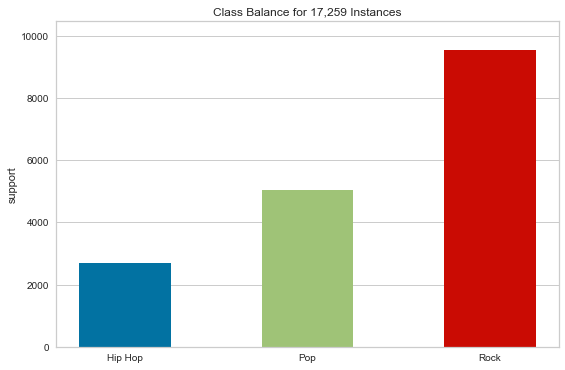

<AxesSubplot:title={'center':'Class Balance for 17,259 Instances'}, ylabel='support'>

In [72]:
X = g_test.iloc[:,:-1]
y = g_test["genre"]

visualizer = ClassBalance(labels=["Hip Hop", "Pop", "Rock"])

visualizer.fit(y)        
visualizer.show() 

In [74]:
g_train.to_csv('g_train')
g_test.to_csv('g_test')


upload_file_to_bucket('music-lyrics-chain','g_train')
upload_file_to_bucket('music-lyrics-chain','g_test')

'https://music-lyrics-chain.s3.amazonaws.com/g_test'